# Descriptive analyses

This notebook conducts the descriptive analyses presented in my thesis. Note that the figures are numbered according to their location within my thesis, not within this notebook.

## Import modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textwrap import wrap
from string import punctuation
import matplotlib.lines as lines
import matplotlib.patches as mpatches
from numpy.core.defchararray import add

## Functions and mapping

In [2]:
def clean(text):
    return [w.strip(punctuation) for w in text.strip().split() if w.strip(punctuation) != '']

In [3]:
sector_dict = {'Automobiles and Components (Primary)':'Auto',
           'Consumer Durables and Apparel (Primary)':'Durables \n& \napparel', 
           'Consumer Services (Primary)':'Services',
           'Retailing (Primary)':'Retail',
           'Food and Staples Retailing (Primary)':'Food \nretail',
           'Food, Beverage and Tobacco (Primary)':'Food \n& bev',
           'Household and Personal Products (Primary)':'Household \n& \npersonal'}
topic_group_mapping = {'Management systems':'Actions','Deforestation':'Environment',
                       'Human rights':'Social','Employee health & safety':'Social',
                       'Resource usage':'Environment',
                       'Certifications & training':'Actions',
                       'Collaborations & partnerships':'Actions',
                       'Plans and progress':'Actions',
                       'Governance & stakeholders':'Actions','Policies':'Actions',
                       'Product quality':'Social',
                       'Diversity & inclusion':'Social','Junk':None,'Agriculture':'Environment',
                       'Risk assessments':'Actions','Chemicals':'Environment',
                       'Transportation & logistics':'Environment',
                       'Society':'Social','Store operations':'Social',
                       'Materials & packaging':'Environment'}

## Import data

In [4]:
company_details_pivoted = pd.read_pickle('../Data/Variable dataframes/company_details_pivoted.pkl')
esg_urls_pd = pd.read_pickle('../Data/Variable dataframes/esg_urls_pd.pkl')
full_report_details_df = pd.read_pickle('../Data/Variable dataframes/full_report_details_df.pkl')
hand_labelled_data = pd.read_pickle('../Data/Variable dataframes/hand_labelled_data.pkl')
paragraph_level_all = pd.read_pickle('../Data/Variable dataframes/paragraph_level_all.pkl')
paragraphs_w_topics = pd.read_pickle('../Data/paragraphs_w_topics.pkl')

In [5]:
# Merge with company details
co_cols = ['Exchange-Ticker', 'Watch Lists',
       'industry_classifications', 'Year Founded',
       'main_industry', 'activist_investors',
       'avg_price_volatility', 'Sensitive', 'Year',
       'book_val_per_share',
       'market_cap','log_market_cap', 'ROA',
       'liabilities_to_assets',
       'total_revenue', 'Age',
       'esg_controversies_score', 'Workforce_controversies_bool',
           'Human_rights_controversies_bool', 'Community_controversies_bool',
           'Product_controversies_bool', 'Env_controversies_bool',
           'Soc_controversies_bool', 'Controversies_all_bool',
       'board_gender_diversity',
       'sustainability_comp_incentives',
       'exec_gender_diversity',
       'board_ethnic_diversity',
       'board_cultural_diversity', 'global_compact',
        'current_rri_mean', 'current_rri_min', 'current_rri_max',
        'Product_or_process_perc_y', 'Product_perc_y', 'Process_perc_y']

# Merge with company details
paragraph_level_all_expanded = paragraph_level_all.merge(full_report_details_df[['Exchange-Ticker',
                                                                               'Year']], 
                                                       right_index=True, 
                                                       left_on='Filename')
paragraph_level_all_expanded = paragraph_level_all_expanded.merge(company_details_pivoted[co_cols], on=['Exchange-Ticker',
                                                                               'Year'])

# Merge with company details
predicted_labels = paragraph_level_all[paragraph_level_all['Supply_Chain']=='Yes']
predicted_labels_expanded = predicted_labels.merge(full_report_details_df[['Exchange-Ticker',
                                                                               'Year']], 
                                                       right_index=True, 
                                                       left_on='Filename')
predicted_labels_expanded = predicted_labels_expanded.merge(company_details_pivoted[co_cols], on=['Exchange-Ticker',
                                                                               'Year'])

# Merge with company details
hand_labelled_data_expanded = hand_labelled_data.merge(full_report_details_df[['Exchange-Ticker',
                                                                               'Year']], 
                                                       right_index=True, 
                                                       left_on='Filename')
hand_labelled_data_expanded = hand_labelled_data_expanded.merge(company_details_pivoted[co_cols], on=['Exchange-Ticker',
                                                                               'Year'])

full_report_details_df_expanded = full_report_details_df.merge(company_details_pivoted[co_cols], on=['Exchange-Ticker',
                                                                               'Year'])

## Report data summary

In [6]:
print(f"Number of reports: {len(full_report_details_df)}")
print(f"Number of pages: {full_report_details_df['Num_pages'].sum()}")
print(f"Has text: {len(company_details_pivoted[company_details_pivoted['Num_paras'].notna()])}")

Number of reports: 1133
Number of pages: 89491.0
Has text: 1105


### Company reporting characteristics

In [7]:
print(f"Any reports: {sum(esg_urls_pd['Years with reports']>0)}")
print(f"No reports or info: {sum(esg_urls_pd['No reports or info'].notna())}")
print(f"In integrated/annual reports: {sum(esg_urls_pd['In integrated reports'].notna())}")
print(f"Non-English reporting: {sum(esg_urls_pd['Non-English'].notna())}")
print(f"No reports, but some info on website: {sum(esg_urls_pd['No reports, but some info on website'].notna())}")
print(f"Some separate ESG reports, other years in integrated reports: {len(esg_urls_pd[(esg_urls_pd['In integrated reports'].notna()) & (esg_urls_pd['Years with reports']>0)])}")

Any reports: 198
No reports or info: 4
In integrated/annual reports: 32
Non-English reporting: 2
No reports, but some info on website: 18
Some separate ESG reports, other years in integrated reports: 16


### Company-year descriptive stats

In [8]:
# Get statistics only for valid company-year observations
comp_year_obs = company_details_pivoted[company_details_pivoted['Num_paras'].notna()]

In [9]:
display(comp_year_obs[['Market_to_process_log','Env_market_to_process_log',
                       'Soc_market_to_process_log','Env_to_social_log']].describe().T.round(3))

,count,mean,std,min,25%,50%,75%,max
Market_to_process_log,1105.0,-1.391,1.260,-4.615,-1.804,-1.196,-0.718,4.615
Env_market_to_process_log,1105.0,-0.865,1.201,-4.615,-1.271,-0.674,-0.208,4.615
Soc_market_to_process_log,1105.0,-1.644,1.188,-4.615,-2.269,-1.397,-0.868,3.536
Env_to_social_log,1105.0,-0.081,1.003,-4.615,-0.422,-0.101,0.212,4.615


In [10]:
desc_stats = comp_year_obs[['Product_or_process_perc_y_detailed','ESG_controversies_numeric','board_gender_diversity',  
               'log_total_revenue','trimmed_ROA','trimmed_book_val_per_share',
               'trimmed_liabilities_to_assets', 'Share_SC', 'Num_paras']].describe().T.round(3)
display(desc_stats)

,count,mean,std,min,25%,50%,75%,max
Product_or_process_perc_y_detailed,1007.0,35.870,11.792,11.000,29.700,33.500,45.700,63.900
ESG_controversies_numeric,961.0,75.755,32.674,0.862,52.778,100.000,100.000,100.000
board_gender_diversity,961.0,24.017,14.200,0.000,14.290,25.000,33.330,75.000
log_total_revenue,1104.0,9.688,1.246,5.891,8.767,9.667,10.557,13.169
trimmed_ROA,1084.0,7.124,4.940,-9.940,4.018,6.230,8.978,25.800
trimmed_book_val_per_share,1094.0,23.051,37.231,-116.500,5.440,11.900,27.275,327.700
trimmed_liabilities_to_assets,1097.0,60.523,21.315,12.600,45.900,59.300,73.100,151.500
Share_SC,1105.0,15.536,9.434,0.787,8.764,14.122,20.000,100.000
Num_paras,1105.0,328.636,308.947,1.000,134.000,248.000,428.000,2990.000


In [11]:
desc_stats.to_excel('../Data/desc-stats.xlsx')

In [12]:
bool_desc = comp_year_obs[['Sensitive','sustainability_comp_incentives']].describe(include='all').T
bool_desc.rename(columns={'freq':'False'}, inplace=True)
bool_desc['False %'] = bool_desc['False'] / bool_desc['count'] * 100
bool_desc['True'] = bool_desc['count'] - bool_desc['False']
bool_desc['True %'] = bool_desc['True'] / bool_desc['count'] * 100
display(bool_desc)

,count,unique,top,False,False %,True,True %
Sensitive,1104,2,False,983,89.039855,121,10.960145
sustainability_comp_incentives,961,2,False,687,71.488033,274,28.511967


In [13]:
report_desc_stats = comp_year_obs[['Process_percent','Environment_process_percent', 
                                   'Social_process_percent', 'Market_percent',
                                   'Environment_market_percent','Social_market_percent',
                                   'Deforestation_percent','Resource usage_percent',
                                   'Agriculture_percent','Chemicals_percent',
                                   'Transportation & logistics_percent',
                                   'Materials & packaging_percent', 
                                   'Human rights_percent','Employee health & safety_percent',
                                   'Product quality_percent','Diversity & inclusion_percent',
                                   'Society_percent','Store operations_percent',
                                   'Management systems_percent',
                                   'Certifications & training_percent',
                                   'Collaborations & partnerships_percent', 
                                   'Plans and progress_percent',
                                   'Governance & stakeholders_percent','Policies_percent',
                                   'Risk assessments_percent']].describe().T
display(report_desc_stats)

,count,mean,std,min,25%,50%,75%,max
Process_percent,1105.0,53.738233,18.031057,0.0,45.000000,54.744526,64.062500,100.000000
Environment_process_percent,1105.0,23.094554,14.209527,0.0,14.545455,21.348315,29.629630,100.000000
Social_process_percent,1105.0,32.464731,16.320588,0.0,22.857143,31.428571,40.816327,100.000000
Market_percent,1105.0,16.714761,13.130873,0.0,8.108108,15.151515,23.076923,100.000000
Environment_market_percent,1105.0,11.491367,11.769875,0.0,4.166667,9.523810,15.789474,100.000000
Social_market_percent,1105.0,7.483783,7.748673,0.0,0.000000,6.250000,11.428571,100.000000
Deforestation_percent,1105.0,3.763915,6.592530,0.0,0.000000,0.000000,5.263158,100.000000
Resource usage_percent,1105.0,7.726765,10.814677,0.0,0.000000,5.555556,10.526316,100.000000
Agriculture_percent,1105.0,2.974312,5.332431,0.0,0.000000,0.000000,4.301075,37.500000
Chemicals_percent,1105.0,2.843577,6.552991,0.0,0.000000,0.000000,3.508772,100.000000


In [14]:
report_desc_stats.to_excel('../Data/report_desc-stats.xlsx')

In [15]:
# Number of observations by sub-sector
company_details_pivoted[company_details_pivoted['Num_paras'].notna()]['main_industry'].value_counts()

Food, Beverage and Tobacco (Primary)         251
Consumer Durables and Apparel (Primary)      215
Automobiles and Components (Primary)         148
Retailing (Primary)                          134
Consumer Services (Primary)                  128
Food and Staples Retailing (Primary)         115
Household and Personal Products (Primary)    113
Name: main_industry, dtype: int64

In [16]:
# Number of observations by region
company_details_pivoted[company_details_pivoted['Num_paras'].notna()]['geo_region'].value_counts()

United States and Canada       471
Europe                         349
Asia / Pacific                 270
Latin America and Caribbean     14
Name: geo_region, dtype: int64

### Figure 1. Distribution of number of years with reports per company

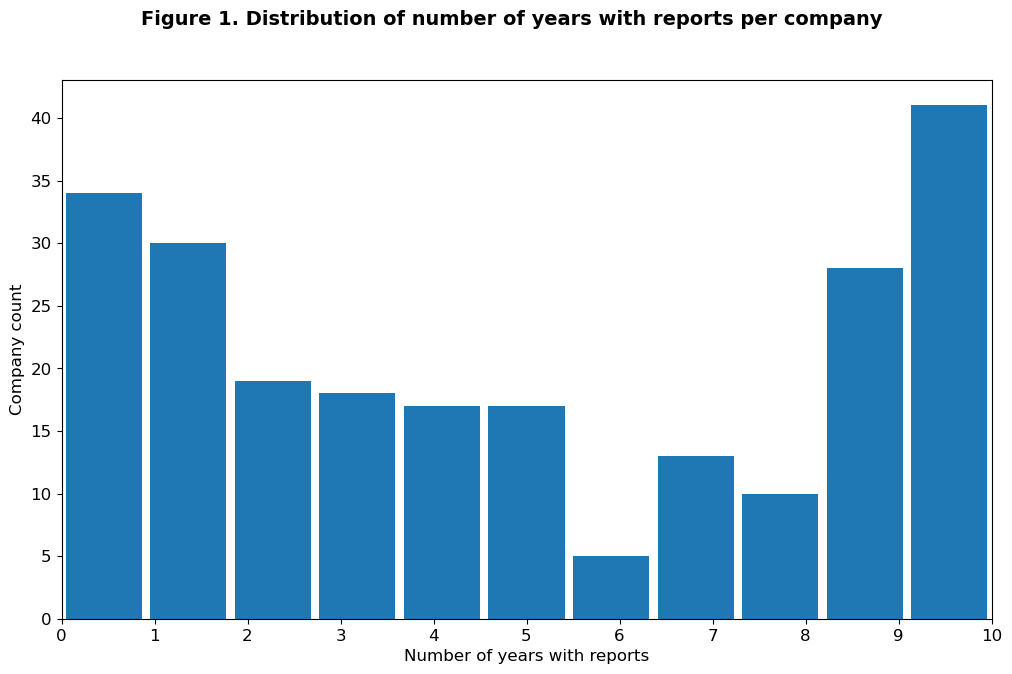

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
esg_urls_pd['Years with reports'].hist(bins=11, ax=ax, rwidth=.9)
ax.grid(False)
ax.margins(x=0)
ax.set_xticks(list(range(0,11)))
ax.set_xticklabels(list(range(0,11)))
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Number of years with reports', fontsize=12)
ax.set_ylabel('Company count', fontsize=12)
plt.suptitle('Figure 1. Distribution of number of years with reports per company', 
             fontsize=14, weight='bold')
plt.savefig("../Figures/report_count_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Figure 2. Number of reports available per year

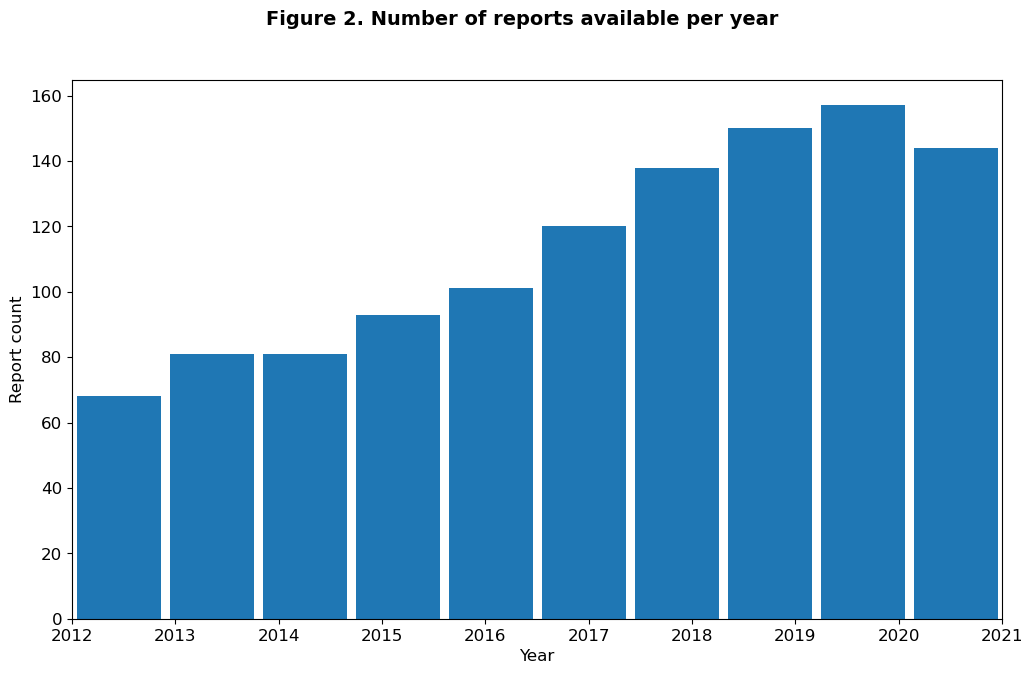

In [18]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
full_report_details_df['Year'].hist(ax=ax, rwidth=.9)
ax.grid(False)
ax.margins(x=0)
ax.set_xticks(list(range(2012,2022)))
ax.set_xticklabels(list(range(2012,2022)))
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Report count', fontsize=12)
plt.suptitle('Figure 2. Number of reports available per year', 
             fontsize=14, weight='bold')
plt.savefig("../Figures/report_year_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Figure 3. Number of pages per report

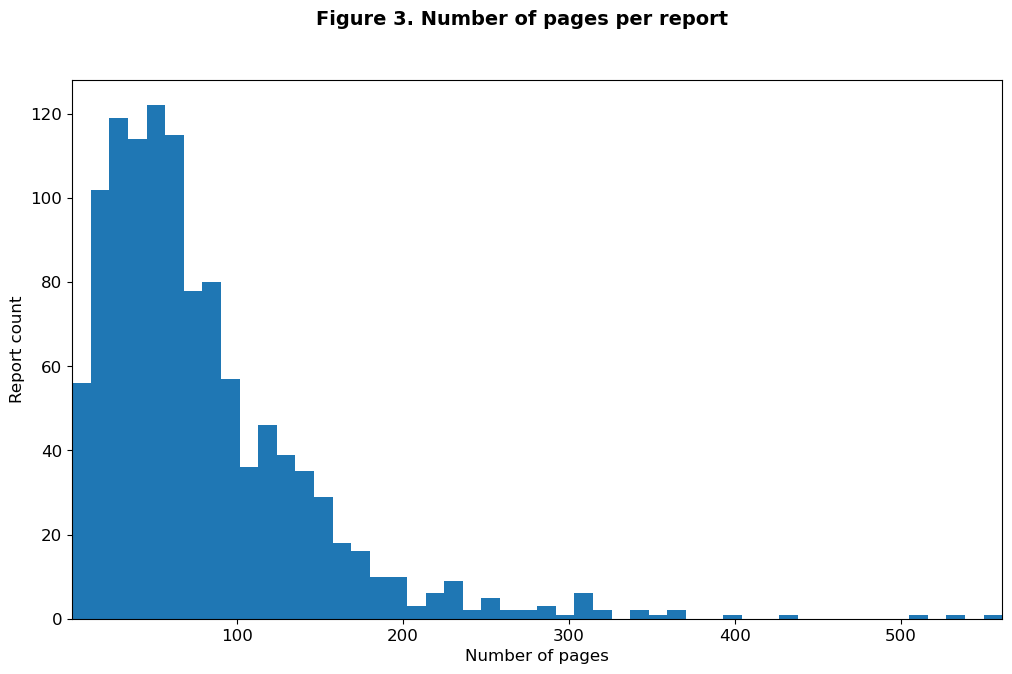

In [19]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
full_report_details_df['Num_pages'].hist(ax=ax, bins=50)
ax.grid(False)
ax.margins(x=0)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Number of pages', fontsize=12)
ax.set_ylabel('Report count', fontsize=12)
plt.suptitle('Figure 3. Number of pages per report', 
             fontsize=14, weight='bold')
plt.savefig("../Figures/report_page_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Figure 4. Average number of pages per report per year

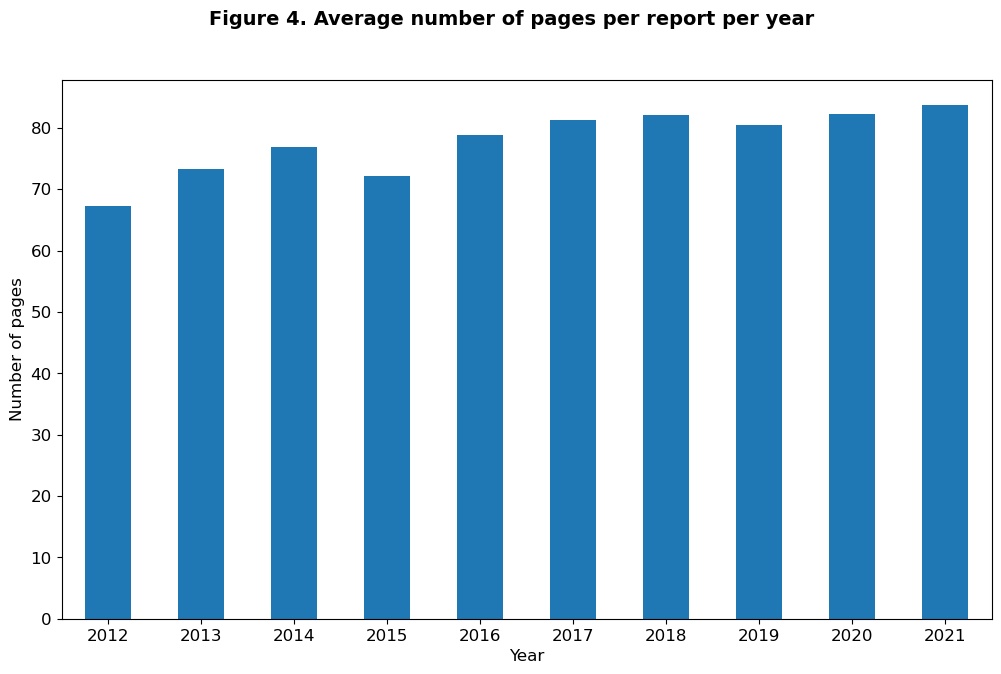

In [20]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
full_report_details_df.groupby('Year')['Num_pages'].mean().plot.bar()
ax.margins(x=0)
ax.tick_params(axis='both',labelsize=12)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of pages', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
plt.suptitle('Figure 4. Average number of pages per report per year', 
             fontsize=14, weight='bold')
plt.savefig("../Figures/year_page_dist.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [21]:
full_report_details_df.groupby('Year')['Num_pages'].mean()

Year
2012    67.235294
2013    73.259259
2014    76.876543
2015    72.172043
2016    78.792079
2017    81.200000
2018    82.021739
2019    80.506667
2020    82.184713
2021    83.652778
Name: Num_pages, dtype: float64

### Scatter plot checks

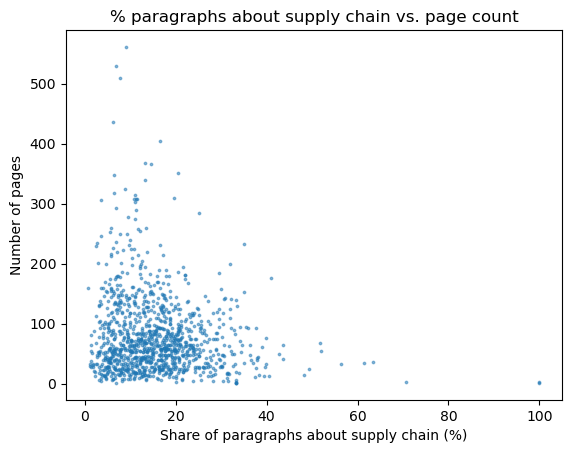

In [22]:
plt.scatter(full_report_details_df['Share_SC'],full_report_details_df['Num_pages'], s=3, alpha=.5)
plt.xlabel('Share of paragraphs about supply chain (%)')
plt.ylabel('Number of pages')
plt.title('% paragraphs about supply chain vs. page count')
plt.show()

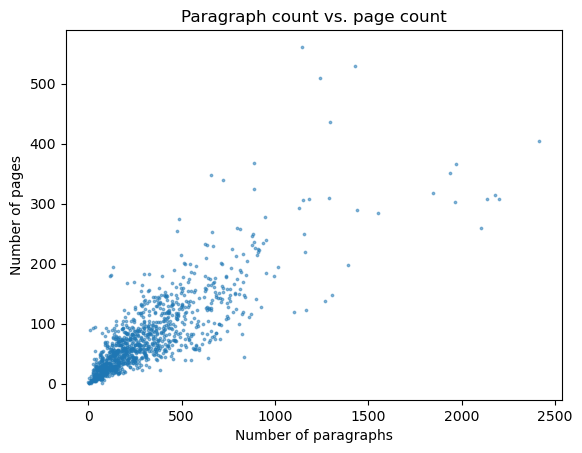

In [23]:
plt.scatter(full_report_details_df['Num_paras'],full_report_details_df['Num_pages'], s=3, alpha=.5)
plt.xlabel("Number of paragraphs")
plt.ylabel("Number of pages")
plt.title('Paragraph count vs. page count')
plt.show()

## Descriptive details for hand-labelled paragraphs

In [24]:
hand_labelled_data.describe().round(3)

,Paragraph_Order,Process_action,Market_action,Social,Environment,Animal welfare
count,5230.000,5230.000,5230.000,5230.000,5230.000,5230.000
mean,275.806,0.501,0.127,0.497,0.460,0.035
std,294.454,0.500,0.333,0.500,0.498,0.184
min,0.000,0.000,0.000,0.000,0.000,0.000
25%,86.000,0.000,0.000,0.000,0.000,0.000
50%,190.500,1.000,0.000,0.000,0.000,0.000
75%,360.750,1.000,0.000,1.000,1.000,0.000
max,2386.000,1.000,1.000,1.000,1.000,1.000


In [25]:
len(hand_labelled_data)

5230

In [26]:
hand_labelled_data['Cleaned paragraph'] = hand_labelled_data['Paragraph'].apply(clean)
print(f"Paragraphs longer than BERT limit: {len(hand_labelled_data[hand_labelled_data['Cleaned paragraph'].map(len) > 512])}")
print(f"% of paragraphs longer than limit: {len(hand_labelled_data[hand_labelled_data['Cleaned paragraph'].map(len) > 512]) / len(hand_labelled_data) * 100:.4f}%")

Paragraphs longer than BERT limit: 26
% of paragraphs longer than limit: 0.4971%


### Figure 6. Label cross tabulation

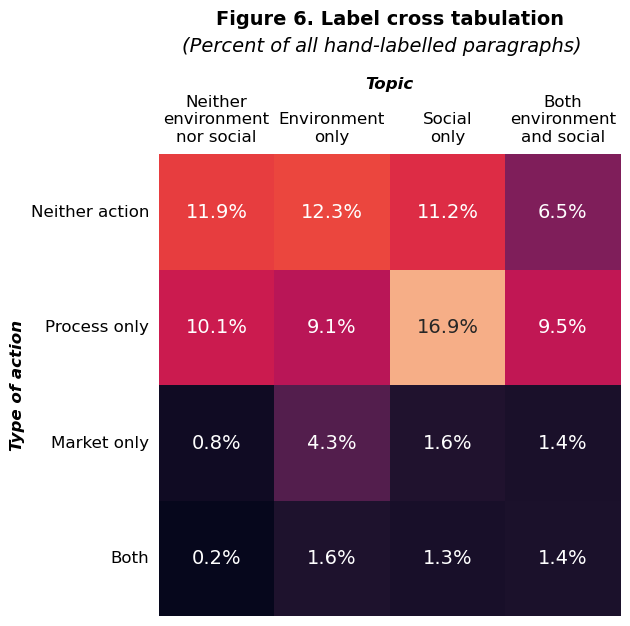

In [27]:
df = pd.crosstab(hand_labelled_data_expanded['Supply chain actions'],
            hand_labelled_data_expanded['Supply chain E/S'], normalize='all')[['Neither','Environment only','Social only','Both']].reindex(['Neither action','Process only','Market only','Both']) * 100

fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.heatmap(df, annot=True, cbar=False, square=True, ax=ax, vmin=0, vmax=20,
            annot_kws={"size": 14}, fmt='.1f')
for t in ax.texts: t.set_text(t.get_text() + "%")
ax.tick_params(axis='both', which='major', labelsize=12, 
                labelbottom = False, bottom=False, top = False, 
                labeltop=True, left=False)
ax.xaxis.set_label_position('top')
ax.set_xticklabels(['Neither\nenvironment\nnor social','Environment\nonly','Social\nonly','Both\nenvironment\nand social'])
ax.set_xlabel('Topic', fontsize=12, style='italic', weight='bold')
ax.set_ylabel('Type of action', fontsize=12, style='italic', weight='bold')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.title('Figure 6. Label cross tabulation\n\n', fontsize=14, weight='bold')
plt.figtext(0.5, 1.05, "(Percent of all hand-labelled paragraphs)", ha="center", fontsize=14, style='italic')
plt.savefig("../Figures/label_crosstab.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Descriptive details for predicted paragraphs

In [28]:
predicted_labels.describe()

,Process_action_pred,Market_action_pred,Social_pred,Environment_pred,Environment_process,Social_process,Environment_market,Social_market,Perc_Contribution,Agriculture,...,Store operations,Transportation & logistics,Process_action_alt,Social_alt,Market_action_alt,Environment_alt,Environment_process_alt,Social_process_alt,Environment_market_alt,Social_market_alt
count,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,...,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000,52299.000000
mean,0.549265,0.172623,0.499589,0.447561,0.221955,0.317195,0.110863,0.080288,0.398577,0.033251,...,0.018031,0.040536,0.419740,0.454005,0.103654,0.478632,0.396107,0.147594,0.070977,0.042639
std,0.497572,0.377924,0.500005,0.497247,0.415565,0.465389,0.313965,0.271742,0.140806,0.179293,...,0.133065,0.197215,0.493521,0.497885,0.304814,0.499548,0.489092,0.354700,0.256788,0.202045
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.294600,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.372900,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.479300,0.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.971200,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
# Number of paragraphs longer than limit
print(f"Paragraphs longer than BERT limit: {len(predicted_labels[predicted_labels['Cleaned paragraph'].map(len) > 512])}")
# Percent of paragraphs longer than limit
print(f"% of paragraphs longer than limit: {len(predicted_labels[predicted_labels['Cleaned paragraph'].map(len) > 512]) / len(predicted_labels) * 100:.4f}%")

Paragraphs longer than BERT limit: 263
% of paragraphs longer than limit: 0.5029%


### Figure 9. Predicted labels by sub-sector and over time

In [30]:
def plot_summary(df, groupby, column, ax, label_cols, colors, title, kind, legend=False):
    grouped_labels = df.groupby(groupby)[column].value_counts(normalize=True).mul(100).unstack(column).fillna(0)
    grouped_labels = grouped_labels[label_cols]
    if kind=='bar': 
        stacked = True
    else:
        stacked = False
    grouped_labels.plot(kind=kind, stacked=False, ax=ax, color=colors)
    if legend == True:
        leg = ax.legend(bbox_to_anchor=(0.4, 1.23), ncol=4, prop={'size': 10})
        leg.set_in_layout(False)
    else:
        leg = ax.legend()
        leg.remove()
    if groupby=='main_industry':
        labels = [sector_dict[label] for label in grouped_labels.index.to_list()]
        ax.set_xticklabels(labels=labels, fontsize=10, wrap=True, rotation=0)
    else:
        labels = [int(label) for label in grouped_labels.index.to_list()]
        ax.set_xticks(labels)
        ax.tick_params(axis='x', labelsize=10, rotation=0)
    ax.set_title(title)
    ax.set_ylabel('Percent of paragraphs')

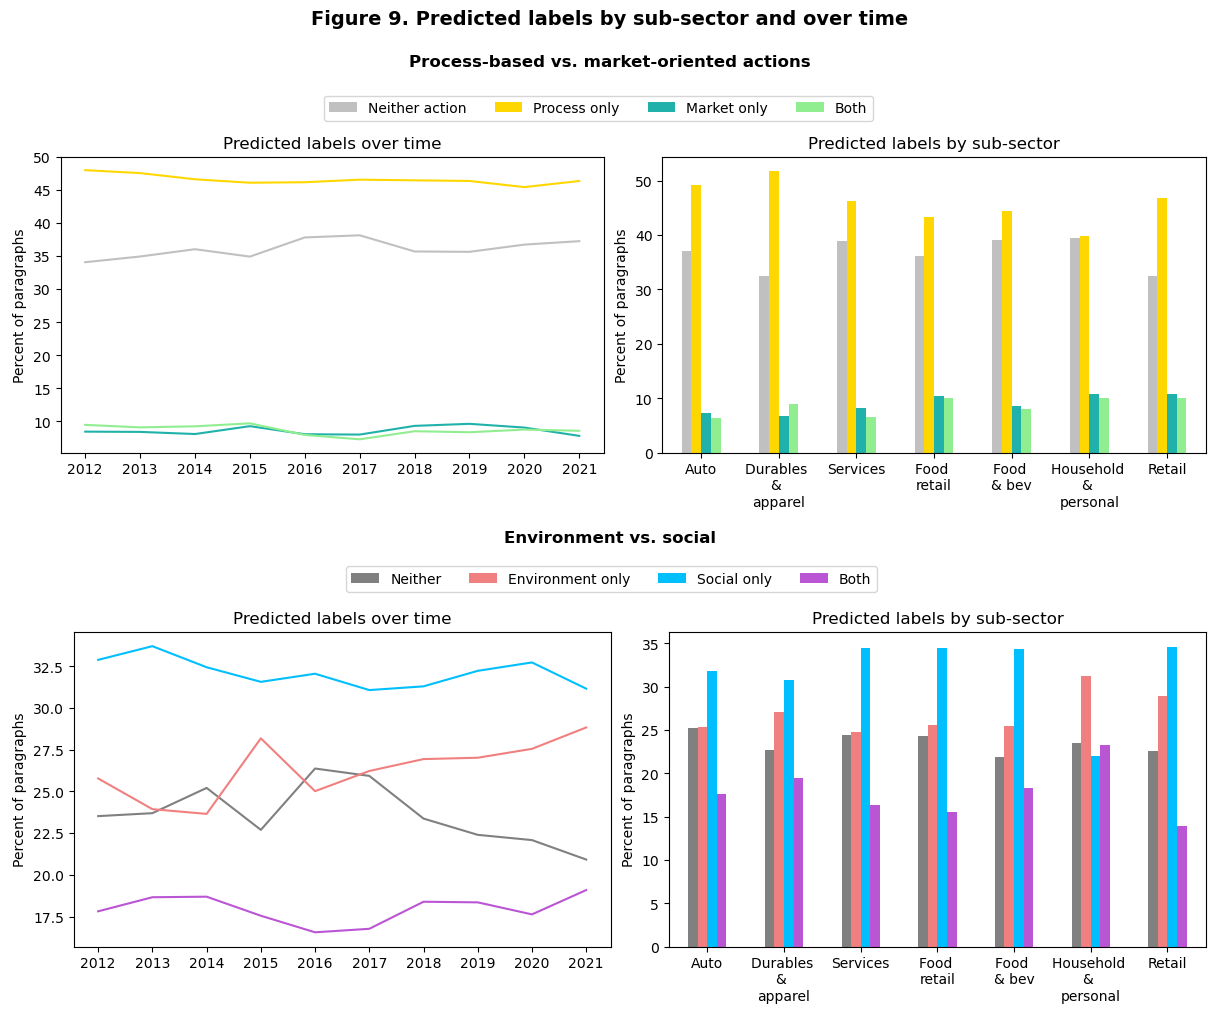

In [31]:
plotting_params = {1: {'groupby':'Year', 'column':'Supply chain actions',
                       'label_cols':['Neither action','Process only','Market only','Both'], 
                       'colors':['silver','gold','lightseagreen','lightgreen'],'kind':'line', 'legend':False, 
                       'title':'Predicted labels over time'}, 
                   2: {'groupby':'main_industry', 'column':'Supply chain actions',
                       'label_cols':['Neither action','Process only','Market only','Both'], 
                       'colors':['silver','gold','lightseagreen','lightgreen'],'kind':'bar', 'legend':True, 
                       'title':'Predicted labels by sub-sector'},
                   3: {'groupby':'Year', 'column':'Supply chain E/S',
                       'label_cols':['Neither','Environment only','Social only','Both'], 
                       'colors':['gray','lightcoral','deepskyblue','mediumorchid'],'kind':'line', 'legend':False, 
                       'title':'Predicted labels over time'}, 
                   4: {'groupby':'main_industry', 'column':'Supply chain E/S',
                       'label_cols':['Neither','Environment only','Social only','Both'], 
                       'colors':['gray','lightcoral','deepskyblue','mediumorchid'],'kind':'bar', 'legend':True, 
                       'title':'Predicted labels by sub-sector'}}

fig = plt.figure(constrained_layout=True, figsize=(12,10))
subfigs = fig.subfigures(nrows=2, ncols=1)

ax1, ax2 = subfigs[0].subplots(nrows=1, ncols=2)
ax3, ax4 = subfigs[1].subplots(nrows=1, ncols=2)

for ax, params in zip([ax1, ax2, ax3, ax4], plotting_params.values()):
    groupby = params['groupby']
    column = params['column']
    label_cols = params['label_cols']
    colors = params['colors']
    legend = params['legend']
    title = params['title']
    kind = params['kind']
    plot_summary(predicted_labels_expanded, groupby, column, ax, label_cols, colors, title, kind, legend)
    ax.set_xlabel('')
    #ax.set_ylim(bottom=0,top=60)
    
fig.suptitle('Figure 9. Predicted labels by sub-sector and over time', fontsize=14, weight='bold')
subfigs[0].suptitle('\nProcess-based vs. market-oriented actions\n\n\n',fontsize=12, weight='bold')
subfigs[1].suptitle('Environment vs. social\n\n\n',fontsize=12, weight='bold')

fig.set_constrained_layout_pads(hspace=0.03)
plt.savefig("../Figures/pred_summary.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Topics

In [32]:
import pickle
with open("../Data/topic_model_results.txt", "rb") as f:
    topic_model_results = pickle.load(f)

### Figure 8. Coherence scores by number of topics

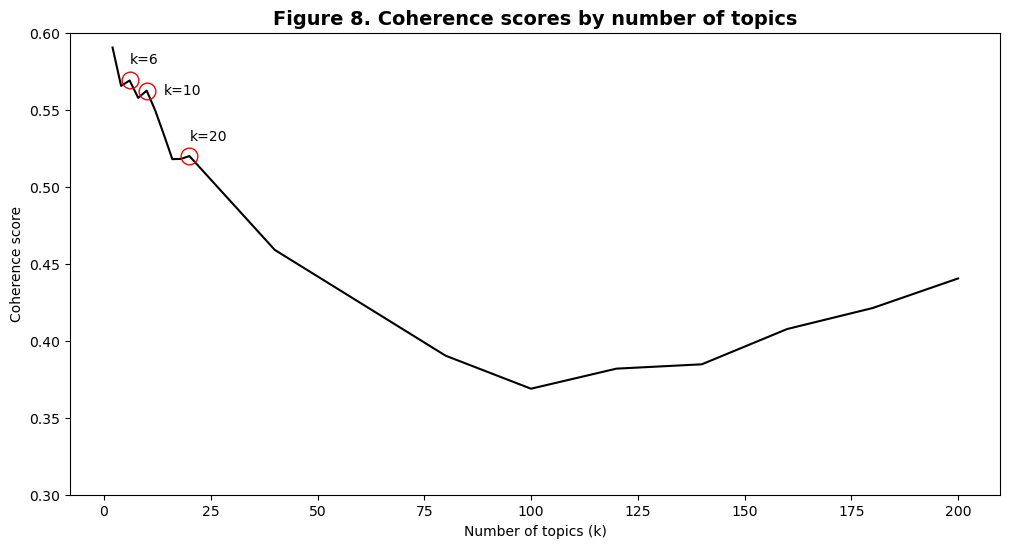

In [33]:
topics = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 40, 80, 100, 120, 140, 160, 180, 200]
coherences = [topic_model_results[t]['coherence'] for t in topics]
fig, ax = plt.subplots(1,1,figsize=(12,6))
ax.plot(topics, coherences, color='black')
ax.set_ylim(.3,.6)
ax.plot(6,topic_model_results[6]['coherence'],'o',fillstyle='none',markersize=12, color='red')
ax.text(6, .58, 'k=6')
ax.plot(10,topic_model_results[10]['coherence'],'o',fillstyle='none',markersize=12, color='red')
ax.text(14, .56, 'k=10')
ax.plot(20,topic_model_results[20]['coherence'],'o',fillstyle='none',markersize=12, color='red')
ax.text(20, .53, 'k=20')
plt.xlabel("Number of topics (k)")
plt.ylabel("Coherence score")
plt.title('Figure 8. Coherence scores by number of topics', fontsize=14, weight='bold')
plt.savefig("../Figures/topic_coherence.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Figure 10. Number of supply chain paragraphs per topic

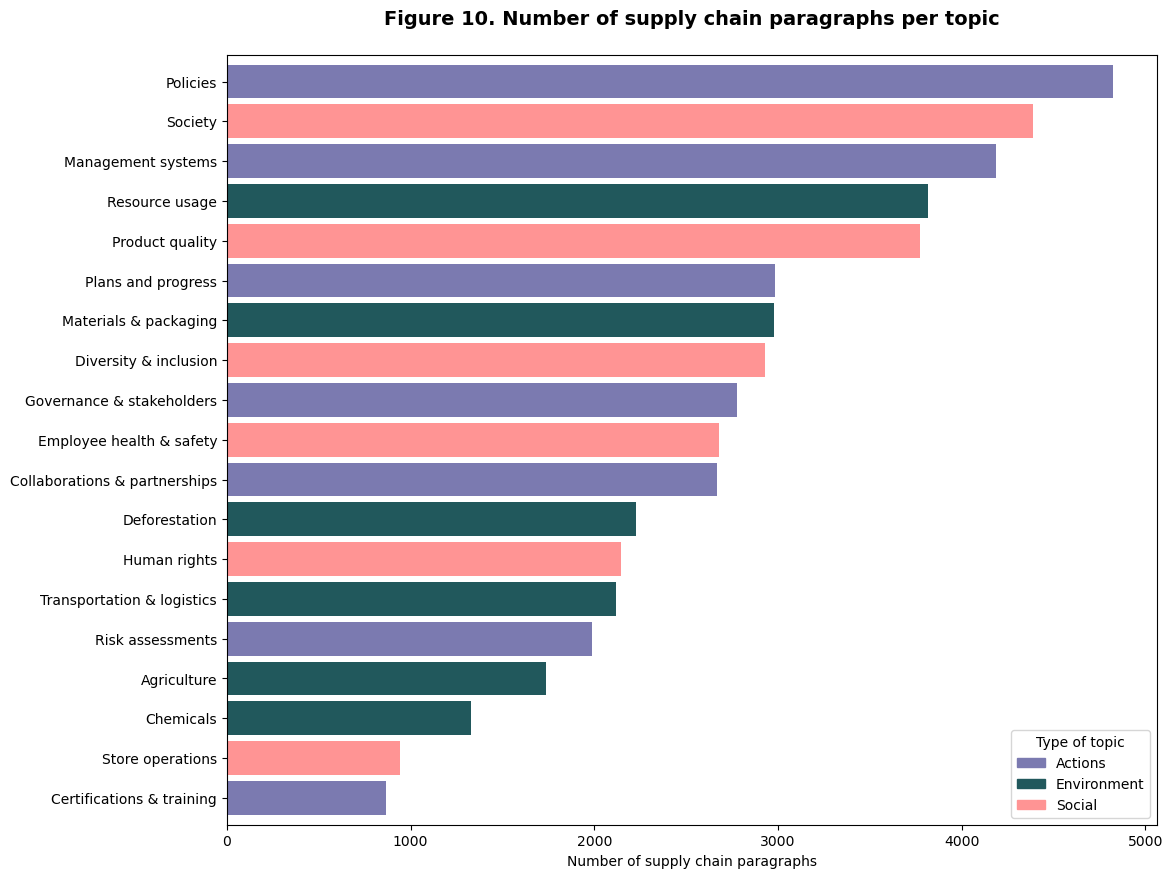

In [34]:
map_group_color = {"Environment": "#21585c", "Social": "#ff9494", "Actions":'#7b7ab0'}
map_color_group = {v:k for k,v in map_group_color.items()}
fig, ax = plt.subplots(1,1,figsize=(12,10))
data = paragraphs_w_topics["Dominant_Topic_Named"].value_counts().sort_values()
data = data.filter(items=[cat for cat in list(data.index) if cat != 'Junk'])

bh = data.plot.barh(width=.85, color = [map_group_color[topic_group_mapping[cat]] for cat in list(data.index)], 
               ax=ax)
patch1 = mpatches.Patch(color='#7b7ab0', label='Actions')
patch2 = mpatches.Patch(color='#21585c', label='Environment')
patch3 = mpatches.Patch(color='#ff9494', label='Social')

ax.set_xlabel('Number of supply chain paragraphs')
plt.legend(handles=[patch1,patch2,patch3], title="Type of topic")

plt.title('Figure 10. Number of supply chain paragraphs per topic\n', 
          fontsize=14, weight='bold')
plt.savefig("../Figures/topic_summary.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Figure 11. Topic prevalence over time

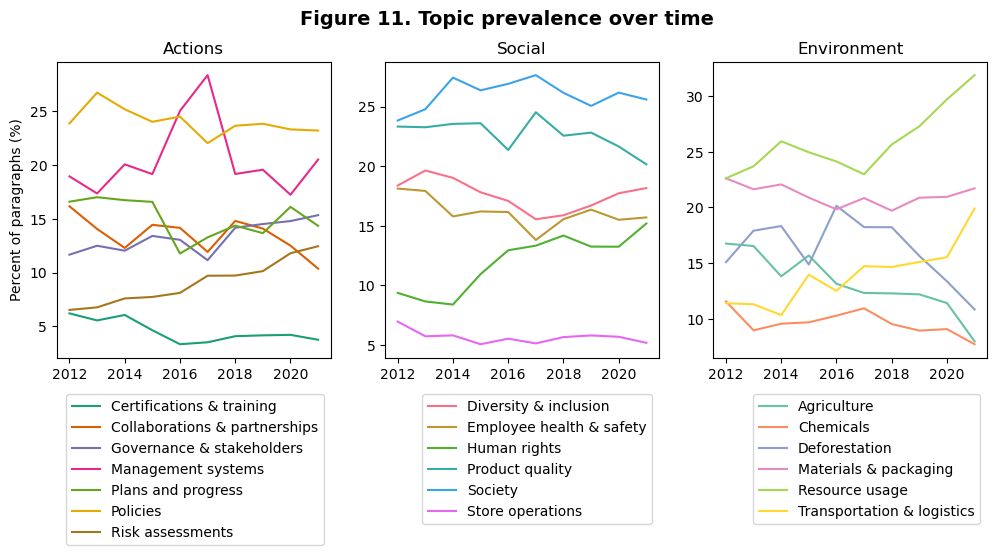

In [35]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,4))

for ax, group, palette in zip([ax1,ax2,ax3],['Actions','Social','Environment'], ['Dark2','husl','Set2']):
    
    df = paragraphs_w_topics[paragraphs_w_topics['Groups']==group]
    topics_by_year = df.groupby("Year")["Dominant_Topic_Named"].value_counts(normalize=True).mul(100).unstack('Dominant_Topic_Named').fillna(0).reset_index()
    
    topics_by_year_m = topics_by_year.melt('Year',var_name='Topics', value_name='Values')

    sns.lineplot(data=topics_by_year_m, x='Year', y='Values', hue='Topics', ax=ax, palette=palette)
    ax.legend(bbox_to_anchor=(1, -0.1))
    if ax == ax1:
        ax.set_ylabel('Percent of paragraphs (%)')
    else:
        ax.set_ylabel('')
    ax.set_title(group)
    ax.set_xlabel('')


fig.subplots_adjust(hspace=10, top=0.85)
fig.set_constrained_layout_pads(hspace=10)
plt.suptitle('Figure 11. Topic prevalence over time\n', fontsize=14, weight='bold')
plt.savefig("../Figures/topic_over_time.pdf", format='pdf', bbox_inches='tight')
plt.show()

## Sub-sector comparison plots

### Figure 12. Supply chain speaking space by sub-sector

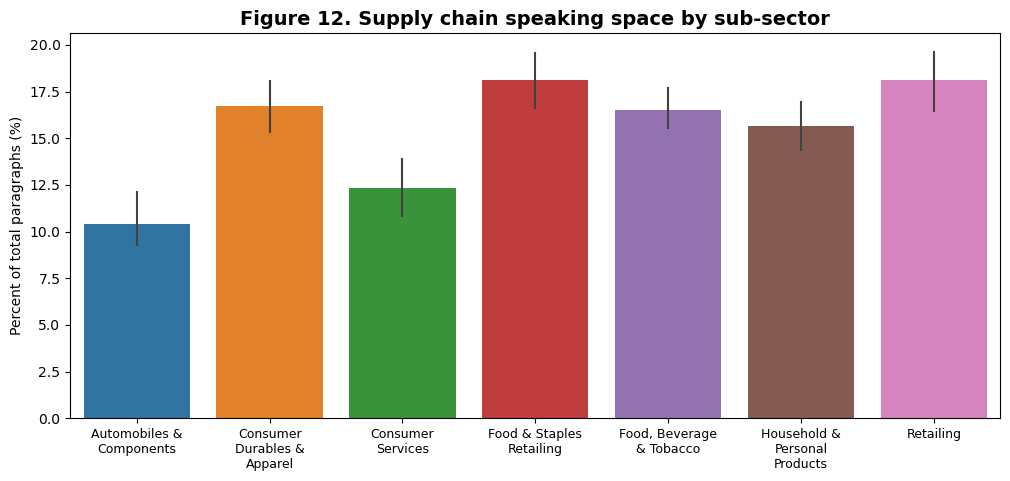

In [36]:
#scp_by_subsector = company_details_pivoted.groupby("main_industry")["Share_SC"].mean().sort_values().reset_index()
fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.barplot(data=company_details_pivoted.sort_values('main_industry'), x='main_industry', y='Share_SC', ax=ax, 
            errwidth=1.5) # color='darkgrey', 
ax.set_title('Figure 12. Supply chain speaking space by sub-sector', fontsize=14, weight='bold')
ax.set_ylabel('Percent of total paragraphs (%)')
ax.set_xlabel('')
labels = [str(label).replace(' (Primary)','').replace('and','&') for label in list(company_details_pivoted.sort_values('main_industry')['main_industry'].unique().dropna())]
labels = ['\n'.join(wrap(l, 15)) for l in labels]
ax.set_xticklabels(labels=labels, fontsize=9,
                   wrap=True, rotation=0)
plt.savefig("../Figures/sc_speaking_space.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Figure 13. Market-to-process speaking space index by sub-sector

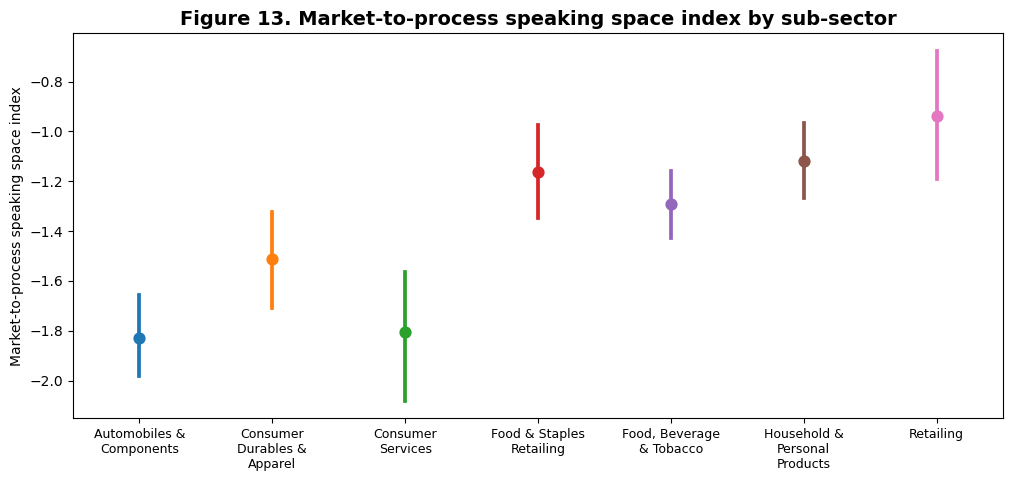

In [37]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.pointplot(data=company_details_pivoted.sort_values('main_industry'), x='main_industry', y='Market_to_process_log', ax=ax, hue='main_industry', join=False) # color='darkgrey', 
ax.set_title('Figure 13. Market-to-process speaking space index by sub-sector', fontsize=14, weight='bold')
ax.set_ylabel('Market-to-process speaking space index')
ax.set_xlabel('')
labels = [str(label).replace(' (Primary)','').replace('and','&') for label in list(company_details_pivoted.sort_values('main_industry')['main_industry'].unique().dropna())]
labels = ['\n'.join(wrap(l, 15)) for l in labels]
ax.set_xticklabels(labels=labels, fontsize=9,
                   wrap=True, rotation=0)
ax.get_legend().remove()
plt.savefig("../Figures/market-to-process.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Figure 14. Environment-to-social speaking space index by sub-sector

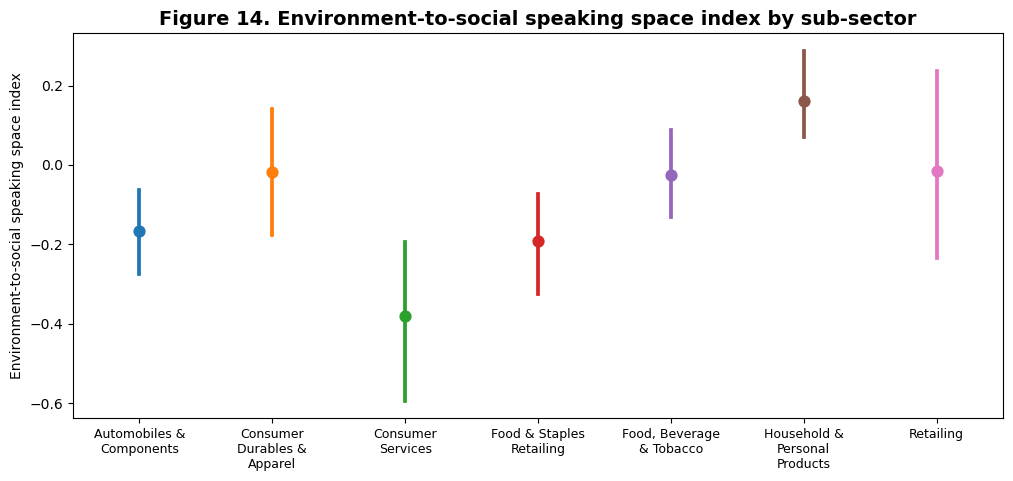

In [38]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
sns.pointplot(data=company_details_pivoted.sort_values('main_industry'), x='main_industry', y='Env_to_social_log', ax=ax, hue='main_industry',
            join=False) # color='darkgrey', errwidth=1.5
ax.set_title('Figure 14. Environment-to-social speaking space index by sub-sector', fontsize=14, weight='bold')
ax.set_ylabel('Environment-to-social speaking space index')
ax.set_xlabel('')
labels = [str(label).replace(' (Primary)','').replace('and','&') for label in list(company_details_pivoted.sort_values('main_industry')['main_industry'].unique().dropna())]
labels = ['\n'.join(wrap(l, 15)) for l in labels]
ax.set_xticklabels(labels=labels, fontsize=9,
                   wrap=True, rotation=0)
ax.get_legend().remove()
plt.savefig("../Figures/env-to-soc.pdf", format='pdf', bbox_inches='tight')
plt.show()

### Figure 15. Speaking space per topic by sub-sector

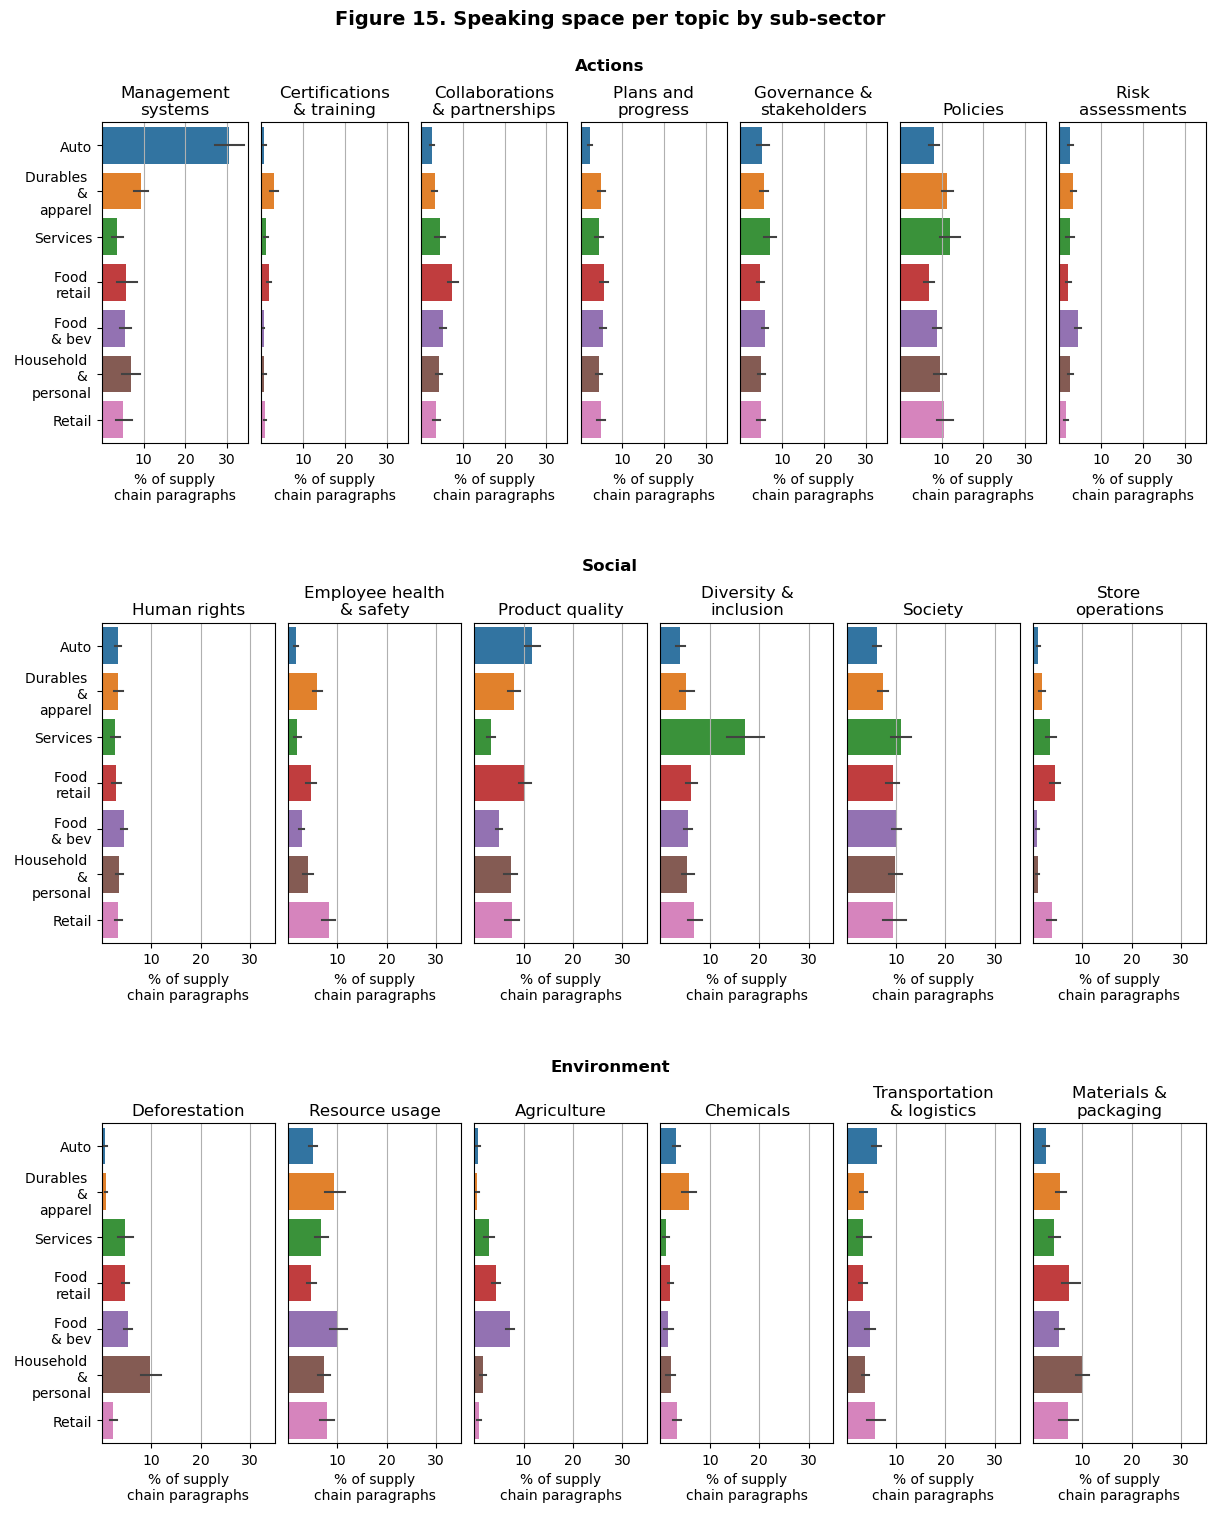

In [39]:
def plot_topic_group_by_sector(group, n, subfig):
    # Plot
    axs = subfig.subplots(nrows=1, ncols=n)

    cats = [k + '_percent' for k,v in topic_group_mapping.items() if v==group]

    for i, (ax, cat) in enumerate(zip(axs, cats)):
        sns.barplot(data=company_details_pivoted.sort_values('main_industry'), x=cat, y='main_industry', 
                    ax=ax, errwidth=1.5) #color='darkgrey', 
        ax.set_title('\n'.join(wrap(cat[:-8], 15)))
        ax.set_xlim(0,35)
        ax.set_xticks([10,20,30])
        ax.set_xlabel('% of supply\nchain paragraphs')
        ax.grid(axis = 'x')
        if i == 0:
            ax.set_yticklabels([sector_dict[k.get_text()] for k in ax.get_yticklabels() if k.get_text() in list(sector_dict.keys())])
            ax.set_ylabel('')
        else:
            ax.set_yticklabels([])
            ax.set_yticks([])
            ax.set_ylabel('')
    subfig.suptitle(group, fontsize=12, weight='bold')

fig = plt.figure(constrained_layout=True, figsize=(12,15))
subfigs = fig.subfigures(nrows=3, ncols=1)
plot_topic_group_by_sector('Actions', 7, subfigs[0])
plot_topic_group_by_sector('Social', 6, subfigs[1])
plot_topic_group_by_sector('Environment', 6, subfigs[2])

fig.suptitle('Figure 15. Speaking space per topic by sub-sector\n', 
             fontsize=14, weight='bold')
fig.set_constrained_layout_pads(hspace=0.1)
plt.savefig("../Figures/topic_by_sector.pdf", format='pdf', bbox_inches='tight')
plt.show()